In [51]:
from PIL import Image
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
import numpy as np

In [ ]:
class VCImage:
    def __init__(self, file_name : str, arr : list = None) -> None:
        self.source = arr

        if arr is None:
            img = Image.open(f'images/{file_name}').convert('L')
            self.source = np.array(img) / 255.0

        self.processed = None
        self.smap = None
        self.name = file_name
        self.bayer_dither(self.source)
        self.quantize(self.proccessed)

    def quantize(self, img, level = 2) -> None:
        h = level ** -1
        self.proccessed = (np.floor(img / h) + .5) * h

    def bayer_dither(self, img) -> None:
        bayer_matrix = np.array([
            [0, 2],
            [3, 1]
        ]) / 4
        h, w = img.shape
        dithered = np.zeros_like(img)

        for i in range(h):
            for j in range(w):
                x = i % 2
                y = j % 2
                dithered[i, j] = 1 if img[i, j] > bayer_matrix[x, y] else 0
        self.proccessed = dithered

    def get_MSE(self, proccessed):
        return np.mean((self.source - proccessed) ** 2)
    
    def get_PSNR(self, proccessed):
        mse = self.get_MSE(proccessed)
        if not mse:
            return float('inf')
        return 20 * np.log10(1 / np.sqrt(mse))
    
    def get_SSSIM(self, proccessed):
        K1 = .01
        K2 = .03
        C1 = K1 ** 2
        C2 = K2 ** 2

        if self.source.shape[0] > 300:
            window_size, sigma = 11, 1.5
        else:
            window_size, sigma = 5, 1
        
        window = np.outer(
            gaussian_filter(np.ones(window_size), sigma),
            gaussian_filter(np.ones(window_size), sigma)
        )

        window /= np.sum(window)

        u1 = gaussian_filter(self.source, sigma, mode='reflect')
        u2 = gaussian_filter(proccessed, sigma, mode='reflect')

        sigma1_sq = gaussian_filter(self.source ** 2, sigma, mode='reflect') - u1 ** 2
        sigma2_sq = gaussian_filter(proccessed ** 2, sigma, mode='reflect') - u2 ** 2
        sigma12 = gaussian_filter(self.source * proccessed, sigma, mode='reflect') - u1 * u2

        l = (2 * u1 * u2 + C1) / (u1 ** 2 + u2 ** 2 + C1)
        c = (2 * np.sqrt(sigma1_sq * sigma2_sq) + C2) / (sigma1_sq + sigma2_sq + C2)
        s = (sigma12 + C2/2) / (np.sqrt(sigma1_sq * sigma2_sq) + C2/2)

        self.smap = l * c * s
        return np.mean(self.smap), self.smap

In [53]:
def generate_sin_img():
    width = height = 256
    x = np.linspace(0, 10 * np.pi, width)
    y = np.linspace(0, 10 * np.pi, height)
    X, Y = np.meshgrid(x, y)
    img = np.sin(X)
    img = (img + 1) / 2
    return img

In [54]:
imgs = [
    VCImage("e1.png"), VCImage("e2.png"), VCImage("e3.png"),
    VCImage("m1.png"), VCImage("m2.png"), VCImage("m3.png"),
    VCImage("h1.png"), VCImage("h2.png"), VCImage("h3.png"),
    VCImage("sin", generate_sin_img()),
]

In [55]:
print('Вычисление MSE')
print('Изображение\tИсходное\tПолученное')

for img in imgs:
    print(
        f'{img.name}\t\t{img.get_MSE(img.source):.4f}\t\t{img.get_MSE(img.proccessed):.4f}'
    )

Вычисление MSE
Изображение	Исходное	Полученное
e1.png		0.0000		0.3994
e2.png		0.0000		0.3018
e3.png		0.0000		0.1039
m1.png		0.0000		0.3397
m2.png		0.0000		0.3270
m3.png		0.0000		0.3329
h1.png		0.0000		0.3447
h2.png		0.0000		0.3007
h3.png		0.0000		0.2863
sin		0.0000		0.2829


In [56]:
print('Вычисление PSNR')
print('Изображение\tИсходное\tПолученное')

for img in imgs:
    print(
        f'{img.name}\t\t{img.get_PSNR(img.source):.4f}\t\t{img.get_PSNR(img.proccessed):.4f}'
    )

Вычисление PSNR
Изображение	Исходное	Полученное
e1.png		inf		3.9861
e2.png		inf		5.2030
e3.png		inf		9.8347
m1.png		inf		4.6895
m2.png		inf		4.8539
m3.png		inf		4.7773
h1.png		inf		4.6250
h2.png		inf		5.2183
h3.png		inf		5.4313
sin		inf		5.4833


In [57]:
print('Получение SSIM')
print("Изображение\tИсходное\tПолученное")
SSIMs = []

for img in imgs:
    default, _ = img.get_SSSIM(img.source)
    processed, smap = img.get_SSSIM(img.proccessed)
    SSIMs.append(smap)
    print(f'{img.name}\t\t{default:.4f}\t\t{processed:.4f}')

Получение SSIM
Изображение	Исходное	Полученное


C:\Users\mayor\AppData\Local\Temp\ipykernel_19948\2060233876.py:69: RuntimeWarning: invalid value encountered in sqrt
  c = (2 * np.sqrt(sigma1_sq * sigma2_sq) + C2) / (sigma1_sq + sigma2_sq + C2)
C:\Users\mayor\AppData\Local\Temp\ipykernel_19948\2060233876.py:70: RuntimeWarning: invalid value encountered in sqrt
  s = (sigma12 + C2/2) / (np.sqrt(sigma1_sq * sigma2_sq) + C2/2)


e1.png		1.0000		nan
e2.png		1.0000		0.2256
e3.png		1.0000		0.7761
m1.png		1.0000		0.0552
m2.png		1.0000		0.1516
m3.png		1.0000		nan
h1.png		1.0000		nan
h2.png		1.0000		0.1352
h3.png		1.0000		0.1553
sin		1.0000		0.1806


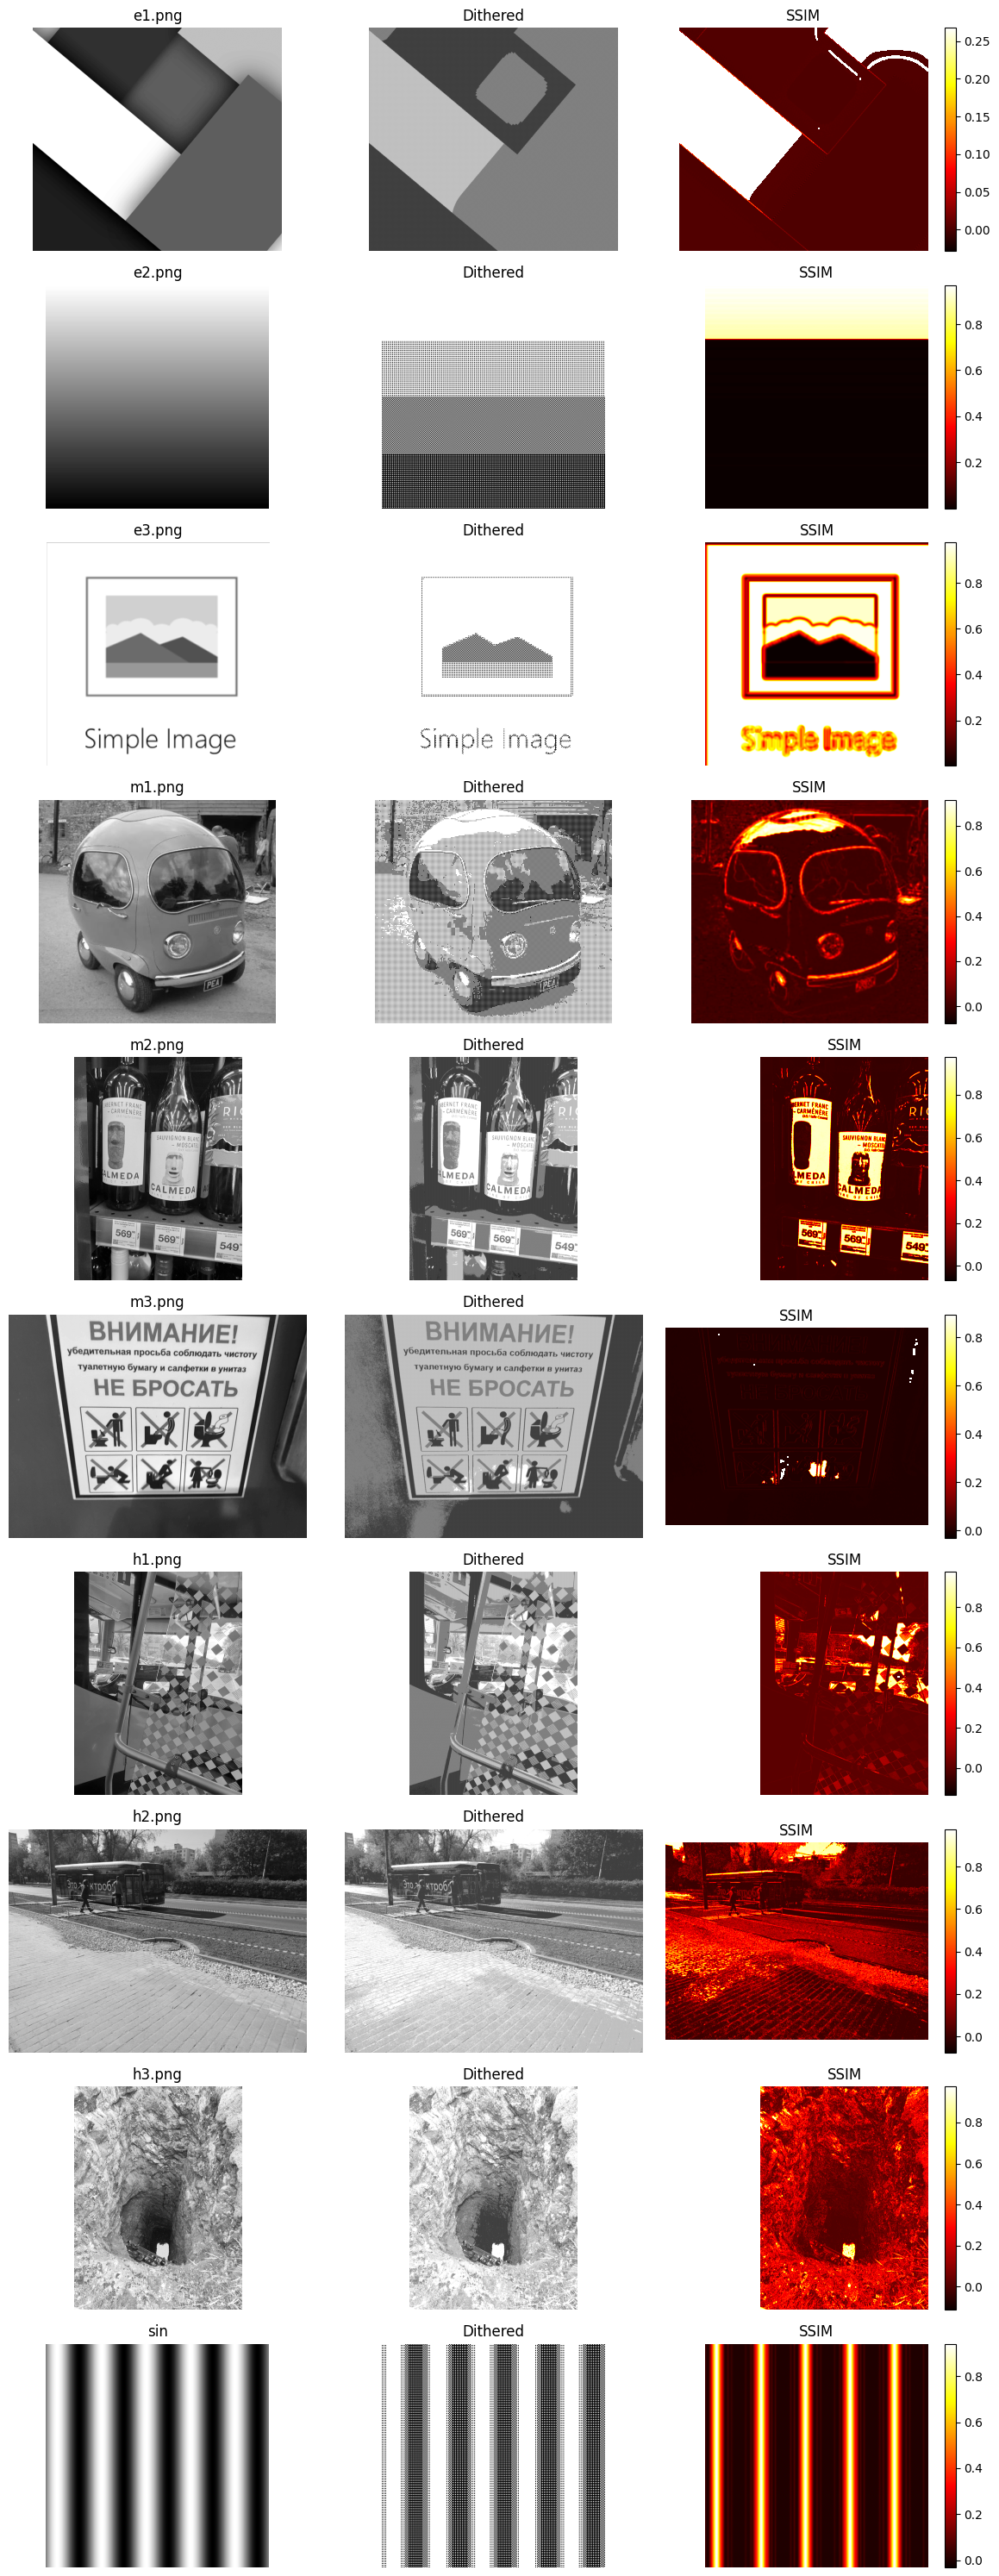

In [58]:
fig, axes = plt.subplots(nrows=len(imgs), ncols=3, figsize=(12, 30))

for i in range(len(imgs)):
    axes[i, 0].imshow(imgs[i].source, cmap='gray')
    axes[i, 0].set_title(f'{imgs[i].name}')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(imgs[i].proccessed, cmap='gray')
    axes[i, 1].set_title(f'Dithered')
    axes[i, 1].axis('off')
    ssim_plot = axes[i, 2].imshow(imgs[i].smap, cmap='hot')
    axes[i, 2].set_title(f'SSIM')
    axes[i, 2].axis('off')
    fig.colorbar(ssim_plot, ax=axes[i,2])

plt.tight_layout()
plt.show()